# CitiBike Dashboard

## 01. Libraries/Imports

In [1]:
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import datetime as dt
from streamlit_keplergl import keplergl_static

C:\Users\Chase\anaconda3\envs\CitiBike\Lib\site-packages\keplergl\keplergl.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


In [2]:
# Import merged csv
ny_data_merged_v2 = pd.read_csv("../02_Data/Prepared_Data/ny_data_merged_v2.csv")

C:\Users\Chase\AppData\Local\Temp\ipykernel_30028\1979977056.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  ny_data_merged_v2 = pd.read_csv("../02_Data/Prepared_Data/ny_data_merged_v2.csv")


## 02. Data Inspection

In [3]:
ny_data_merged_v2.shape

(29838166, 19)

In [4]:
ny_data_merged_v2.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'date', 'avgTemp', '_merge', 'bike_rides_daily',
       'value', 'tripduration'],
      dtype='object')

In [5]:
ny_data_merged_v2.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,date,avgTemp,_merge,bike_rides_daily,value,tripduration
0,4A091640AEC83471,classic_bike,2022-01-01 16:01:22.082,2022-01-01 16:05:11.986,S 4 St & Wythe Ave,5204.05,Kent Ave & S 11 St,5062.01,40.712859,-73.965903,40.707645,-73.968415,member,2022-01-01,11.6,both,20428,1,3.831733
1,7A560D6287C00126,classic_bike,2022-01-01 14:07:04.344,2022-01-01 14:31:57.500,Lexington Ave & E 120 St,7652.04,Amsterdam Ave & W 125 St,7800.03,40.801307,-73.939817,40.813358,-73.956461,member,2022-01-01,11.6,both,20428,1,24.885933
2,4F6F726B809C15E4,classic_bike,2022-01-01 12:02:26.943,2022-01-01 12:14:13.555,Lexington Ave & E 120 St,7652.04,Amsterdam Ave & W 125 St,7800.03,40.801307,-73.939817,40.813358,-73.956461,member,2022-01-01,11.6,both,20428,1,11.776867
3,3BC10DC94FD79955,classic_bike,2022-01-01 22:53:23.508,2022-01-01 23:18:42.881,Cleveland Pl & Spring St,5492.05,Mott St & Prince St,5561.04,40.722104,-73.997249,40.723180,-73.994800,member,2022-01-01,11.6,both,20428,1,25.322883
4,FE4CE7F1CFFD7952,classic_bike,2022-01-01 08:04:51.755,2022-01-01 08:08:07.290,Central Park North & Adam Clayton Powell Blvd,7617.07,E 110 St & Madison Ave,7587.14,40.799484,-73.955613,40.796154,-73.947821,member,2022-01-01,11.6,both,20428,1,3.258917


In [6]:
ny_data_merged_v2.dtypes

ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
date                   object
avgTemp               float64
_merge                 object
bike_rides_daily        int64
value                   int64
tripduration          float64
dtype: object

## 03. Change Date Type

In [7]:
# Change the 'date' column to date-time
ny_data_merged_v2['date'] = pd.to_datetime(ny_data_merged_v2['date'], errors='coerce')

In [8]:
# Work check
ny_data_merged_v2['date'].dtype

dtype('<M8[ns]')

In [9]:
# Double check the dates to ensure no year anomailes
ny_data_merged_v2['date'].dt.year.unique()

array([2022], dtype=int32)

In [10]:
# Set date as index to build a proper time-series plot
weather_2022 = ny_data_merged_v2.set_index('date')

In [11]:
# Work Check for date type change
ny_data_merged_v2.dtypes

ride_id                       object
rideable_type                 object
started_at                    object
ended_at                      object
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
date                  datetime64[ns]
avgTemp                      float64
_merge                        object
bike_rides_daily               int64
value                          int64
tripduration                 float64
dtype: object

## 04. Top 20 Starting Stations

In [12]:
# Agg the stations
ny_data_merged_v2['value'] = 1
station_counts = ny_data_merged_v2.groupby('start_station_name')['value'].count().reset_index()

In [13]:
# Sort the counts in ascending order
station_counts = station_counts.sort_values('value', ascending=False)

In [14]:
# Top 20 stations
top20 = station_counts.head(20)
print(top20)

            start_station_name   value
1587           W 21 St & 6 Ave  129016
1718     West St & Chambers St  123289
495         Broadway & W 58 St  114293
286            6 Ave & W 33 St  106440
8              1 Ave & E 68 St  104856
461         Broadway & E 14 St   98862
485         Broadway & W 25 St   98422
1511   University Pl & E 14 St   97120
463         Broadway & E 21 St   95691
1603           W 31 St & 7 Ave   94208
788            E 33 St & 1 Ave   91003
590   Cleveland Pl & Spring St   90973
29            12 Ave & W 40 St   90414
287            6 Ave & W 34 St   89683
1719      West St & Liberty St   87657
24            11 Ave & W 41 St   87577
1105     Lafayette St & E 8 St   87457
562     Central Park S & 6 Ave   87013
796         E 40 St & Park Ave   85598
328            8 Ave & W 33 St   85051


#### Export

In [35]:
top20.to_csv(r"..\02_Data\Prepared_Data\top_stations_df.csv", index=False)

## 05. Bar Chart

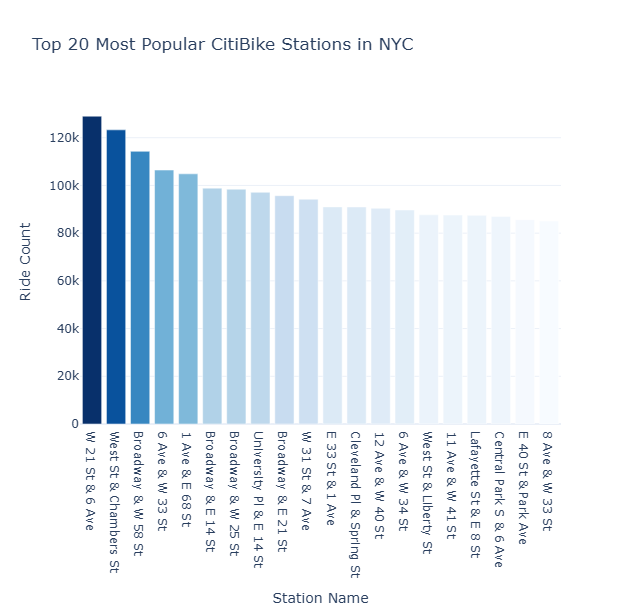

In [15]:
fig = go.Figure(go.Bar(
    x=top20["start_station_name"],
    y=top20["value"],
    marker=dict(
        color=top20["value"],
        colorscale="Blues",
        reversescale=False
    )
))

fig.update_layout(
    title="Top 20 Most Popular CitiBike Stations in NYC",
    xaxis_title="Station Name",
    yaxis_title="Ride Count",
    width=900,
    height=600,
    template="plotly_white"
)

fig.show()


## 06. Dual-Axis Chart

#### Sub-Dataset

In [19]:
# Build a sub-dataset w/the needed columns for daily data
daily_sub_df = (
    ny_data_merged_v2
    .groupby("date", as_index=False)
    .agg({
        "bike_rides_daily": "mean",
        "avgTemp": "mean"
    })
)


In [20]:
# Work check
daily_sub_df.head()

,date,bike_rides_daily,avgTemp
0,2022-01-01,20428.0,11.6
1,2022-01-02,43009.0,11.4
2,2022-01-03,33189.0,1.4
3,2022-01-04,36842.0,-2.7
4,2022-01-05,34230.0,3.2


#### Export

In [33]:
daily_sub_df.to_csv(r"..\02_Data\Prepared_Data\daily_sub_df.csv", index=False)

#### Plotting

In [26]:
# Create subplot with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

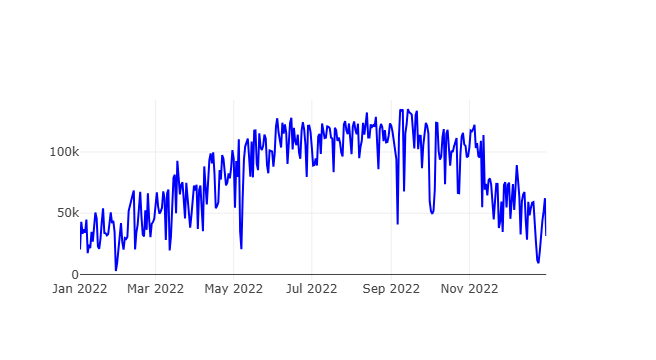

In [27]:
# Add the daily bike rides line (left y-axis)
fig.add_trace(
    go.Scatter(
        x=daily_sub_df["date"],
        y=daily_sub_df["bike_rides_daily"],
        name="Daily Bike Rides",
        line=dict(color="blue")
    ),
    secondary_y=False
)

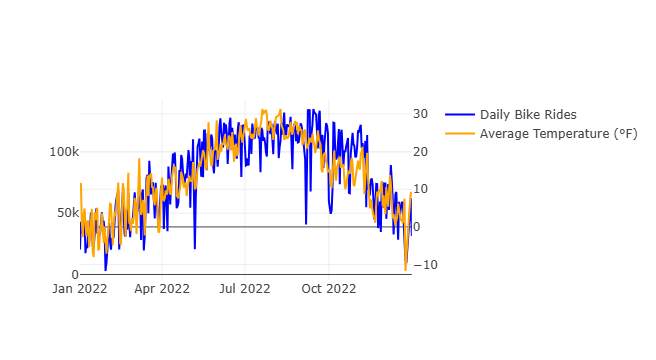

In [28]:
# Add the average temperature line (right y-axis)
fig.add_trace(
    go.Scatter(
        x=daily_sub_df["date"],
        y=daily_sub_df["avgTemp"],
        name="Average Temperature (°F)",
        line=dict(color="orange")
    ),
    secondary_y=True
)

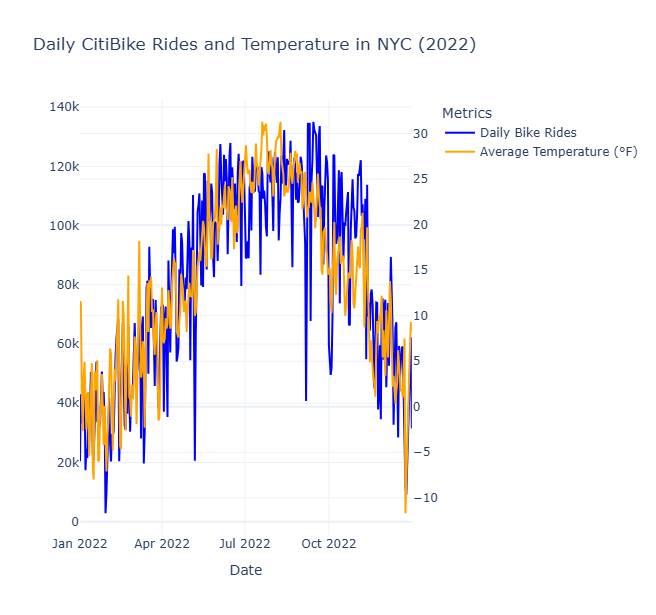

In [29]:
# Update layout: title, axis labels, theme, size

fig.update_layout(
    title="Daily CitiBike Rides and Temperature in NYC (2022)",
    xaxis_title="Date",
    template="plotly_white",
    height=600,
    width=1000,
    legend_title="Metrics"
)

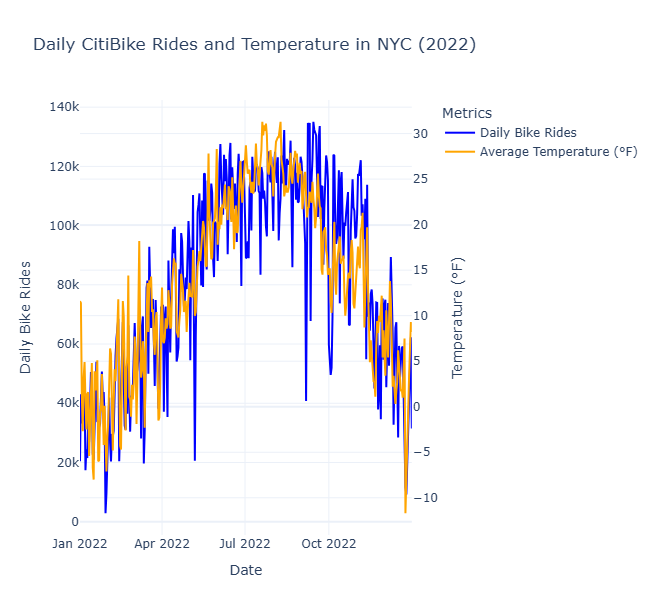

In [30]:
# Label the y-axes

fig.update_yaxes(
    title_text="Daily Bike Rides",
    secondary_y=False
)

fig.update_yaxes(
    title_text="Temperature (°F)",
    secondary_y=True
)
